<a href="https://colab.research.google.com/github/MH-1294/ML_DL/blob/main/new_experiment_custom_light_weight_CNN_XAI_Three-way_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

import kagglehub
faysalmiah1721758_potato_dataset_path = kagglehub.dataset_download('faysalmiah1721758/potato-dataset')

print('Data source import complete.')


Data source import complete.


In [12]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import kagglehub

AUTOTUNE = tf.data.AUTOTUNE

# Step 1: Download dataset
faysalmiah1721758_potato_dataset_path = kagglehub.dataset_download('faysalmiah1721758/potato-dataset')
print("Data download complete.")

DATASET_DIR = faysalmiah1721758_potato_dataset_path

# Step 2: List image paths and labels
class_names = sorted(os.listdir(DATASET_DIR))
file_paths = []
labels = []

for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_DIR, class_name)
    for fname in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, fname))
        labels.append(label_index)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Step 3: 80/10/10 split
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.20, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Step 4: Dataset loading function (with optional augmentation)
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

def load_dataset(file_paths, labels, augment=False, shuffle=True):
    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def process_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMAGE_SIZE)
        image = image / 255.0  # Normalize

        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

        return image, tf.one_hot(label, depth=len(class_names))

    ds = path_ds.map(process_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Step 5: Create datasets
train_ds = load_dataset(X_train, y_train, augment=True)
val_ds = load_dataset(X_val, y_val, augment=False)
test_ds = load_dataset(X_test, y_test, augment=False)

print("Class names:", class_names)


Data download complete.
Train: 1721, Val: 215, Test: 216
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [13]:
import os
import pickle
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_model(model, model_name, train_ds, val_ds, test_ds, class_names, epochs=30):

    os.makedirs('models', exist_ok=True)
    os.makedirs('history', exist_ok=True)


    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model_name = f"{model_name}_{timestamp}"
    model_path = f"models/{model_name}.h5"
    history_path = f"history/{model_name}_history.pkl"
    plot_path = f"history/{model_name}_plot.png"
    cm_path = f"history/{model_name}_confusion_matrix.png"


    print(" Computing class weights...")
    y_train = []
    for _, labels in train_ds:
        y_train.extend(np.argmax(labels.numpy(), axis=1))
    class_weight = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(len(class_names)),
        y=y_train
    )
    class_weight = dict(enumerate(class_weight))
    print(f"Class weights: {class_weight}")


    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)


    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop, checkpoint],
        class_weight=class_weight
    )


    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    # Evaluate
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Predict
    y_true, y_pred = [], []
    for images, labels in test_ds:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Classification Report
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))  # increase size to fix overlap
    disp.plot(ax=ax, cmap='Blues', colorbar=False, xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.show()

    # Accuracy & Loss Plots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

    print(f"\nBest model saved to: {model_path}")
    print(f"Training history saved to: {history_path}")
    print(f"Training plots saved to: {plot_path}")
    print(f"Confusion matrix saved to: {cm_path}")


In [14]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_improved_cnn(input_shape=(256, 256, 3), num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Block 4
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Global Pooling + Dense
    x = layers.Dropout(0.2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


 Computing class weights...
Class weights: {0: np.float64(0.7170833333333333), 1: np.float64(0.7170833333333333), 2: np.float64(4.741046831955923)}
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7856 - loss: 0.5677

54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 301ms/step - accuracy: 0.7871 - loss: 0.5638 - val_accuracy: 0.4651 - val_loss: 4.2256
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9280 - loss: 0.2088 - val_accuracy: 0.4651 - val_loss: 5.4105
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9221 - loss: 0.1818 - val_accuracy: 0.4651 - val_loss: 5.7628
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9065 - loss: 0.2542 - val_accuracy: 0.4651 - val_loss: 7.6614
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9124 - loss: 0.2101 - val_accuracy: 0.4651 - val_loss: 9.0918
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9332 - loss: 0.2147 - val_accuracy: 0.4651 - val_loss: 7.3726
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9524 - loss: 0.1262 - val_accuracy: 0.4651 - val_loss: 7.3491
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9304 - loss: 0.1422

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9308 - loss: 0.1415 - val_accuracy: 0.6233 - val_loss: 2.3776
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9476 - loss: 0.1492

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9475 - loss: 0.1492 - val_accuracy: 0.7070 - val_loss: 0.9887
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9399 - loss: 0.1589

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9399 - loss: 0.1586 - val_accuracy: 0.9349 - val_loss: 0.1516
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9497 - loss: 0.1264 - val_accuracy: 0.8837 - val_loss: 0.2557
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9643 - loss: 0.0964 - val_accuracy: 0.4791 - val_loss: 3.6712
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9405 - loss: 0.1536 - val_accuracy: 0.7023 - val_loss: 1.0592
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9637 - loss: 0.0881

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9637 - loss: 0.0881 - val_accuracy: 0.9581 - val_loss: 0.1077
Epoch 15/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9776 - loss: 0.0514 - val_accuracy: 0.6279 - val_loss: 1.1562
Epoch 16/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9676 - loss: 0.0788 - val_accuracy: 0.9256 - val_loss: 0.1919
Epoch 17/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9396 - loss: 0.1915 - val_accuracy: 0.5442 - val_loss: 6.0520
Epoch 18/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9706 - loss: 0.1134 - val_accuracy: 0.5767 - val_loss: 2.8345
Epoch 19/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9740 - loss: 0.0660 - val_accuracy: 0.9256 - val_loss: 0.1921
Epoch 20/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9777 - loss: 0.0565 - val_accuracy: 0.7721 - val_loss: 0.7718
Epoch 21/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.9797 - loss: 0.0533 - val_accuracy: 0.8651 - 

54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9806 - loss: 0.0449 - val_accuracy: 0.9814 - val_loss: 0.0492
Epoch 23/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9816 - loss: 0.0427 - val_accuracy: 0.9442 - val_loss: 0.1297
Epoch 24/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9848 - loss: 0.0391 - val_accuracy: 0.9581 - val_loss: 0.1296
Epoch 25/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9796 - loss: 0.0506 - val_accuracy: 0.7488 - val_loss: 0.9522
Epoch 26/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9787 - loss: 0.0549 - val_accuracy: 0.9163 - val_loss: 0.3179
Epoch 27/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9781 - loss: 0.0430 - val_accuracy: 0.9395 - val_loss: 0.1825
Epoch 28/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9815 - loss: 0.0447 - val_accuracy: 0.9349 - val_loss: 0.2046
Epoch 29/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9835 - loss: 0.0306 - val_accuracy: 0.5395 -

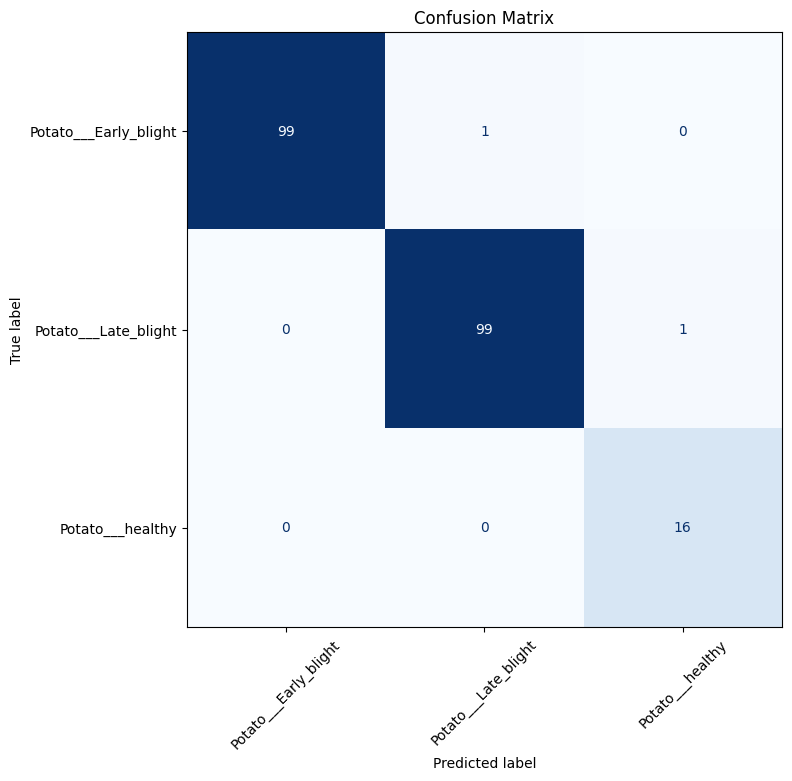

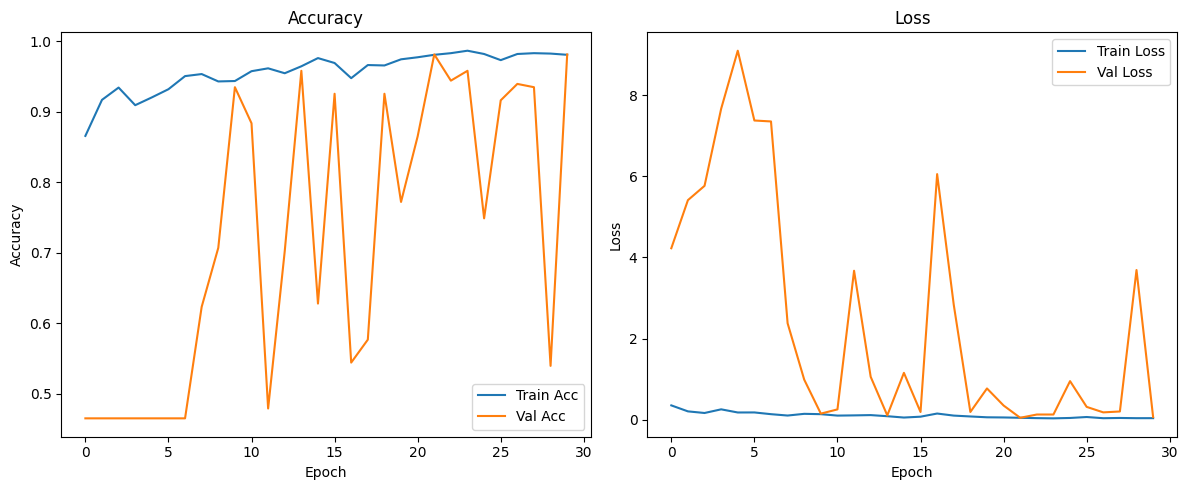


Best model saved to: models/lightweight_cnn_20250709-035811.h5
Training history saved to: history/lightweight_cnn_20250709-035811_history.pkl
Training plots saved to: history/lightweight_cnn_20250709-035811_plot.png
Confusion matrix saved to: history/lightweight_cnn_20250709-035811_confusion_matrix.png


In [15]:
# Build the lightweight CNN model
model = build_improved_cnn()

# Train and evaluate
train_and_evaluate_model(
    model=model,
    model_name="lightweight_cnn",
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    class_names=class_names,
    epochs=50
)


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,219,019 (4.65 MB)

 Trainable params: 406,019 (1.55 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 812,040 (3.10 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


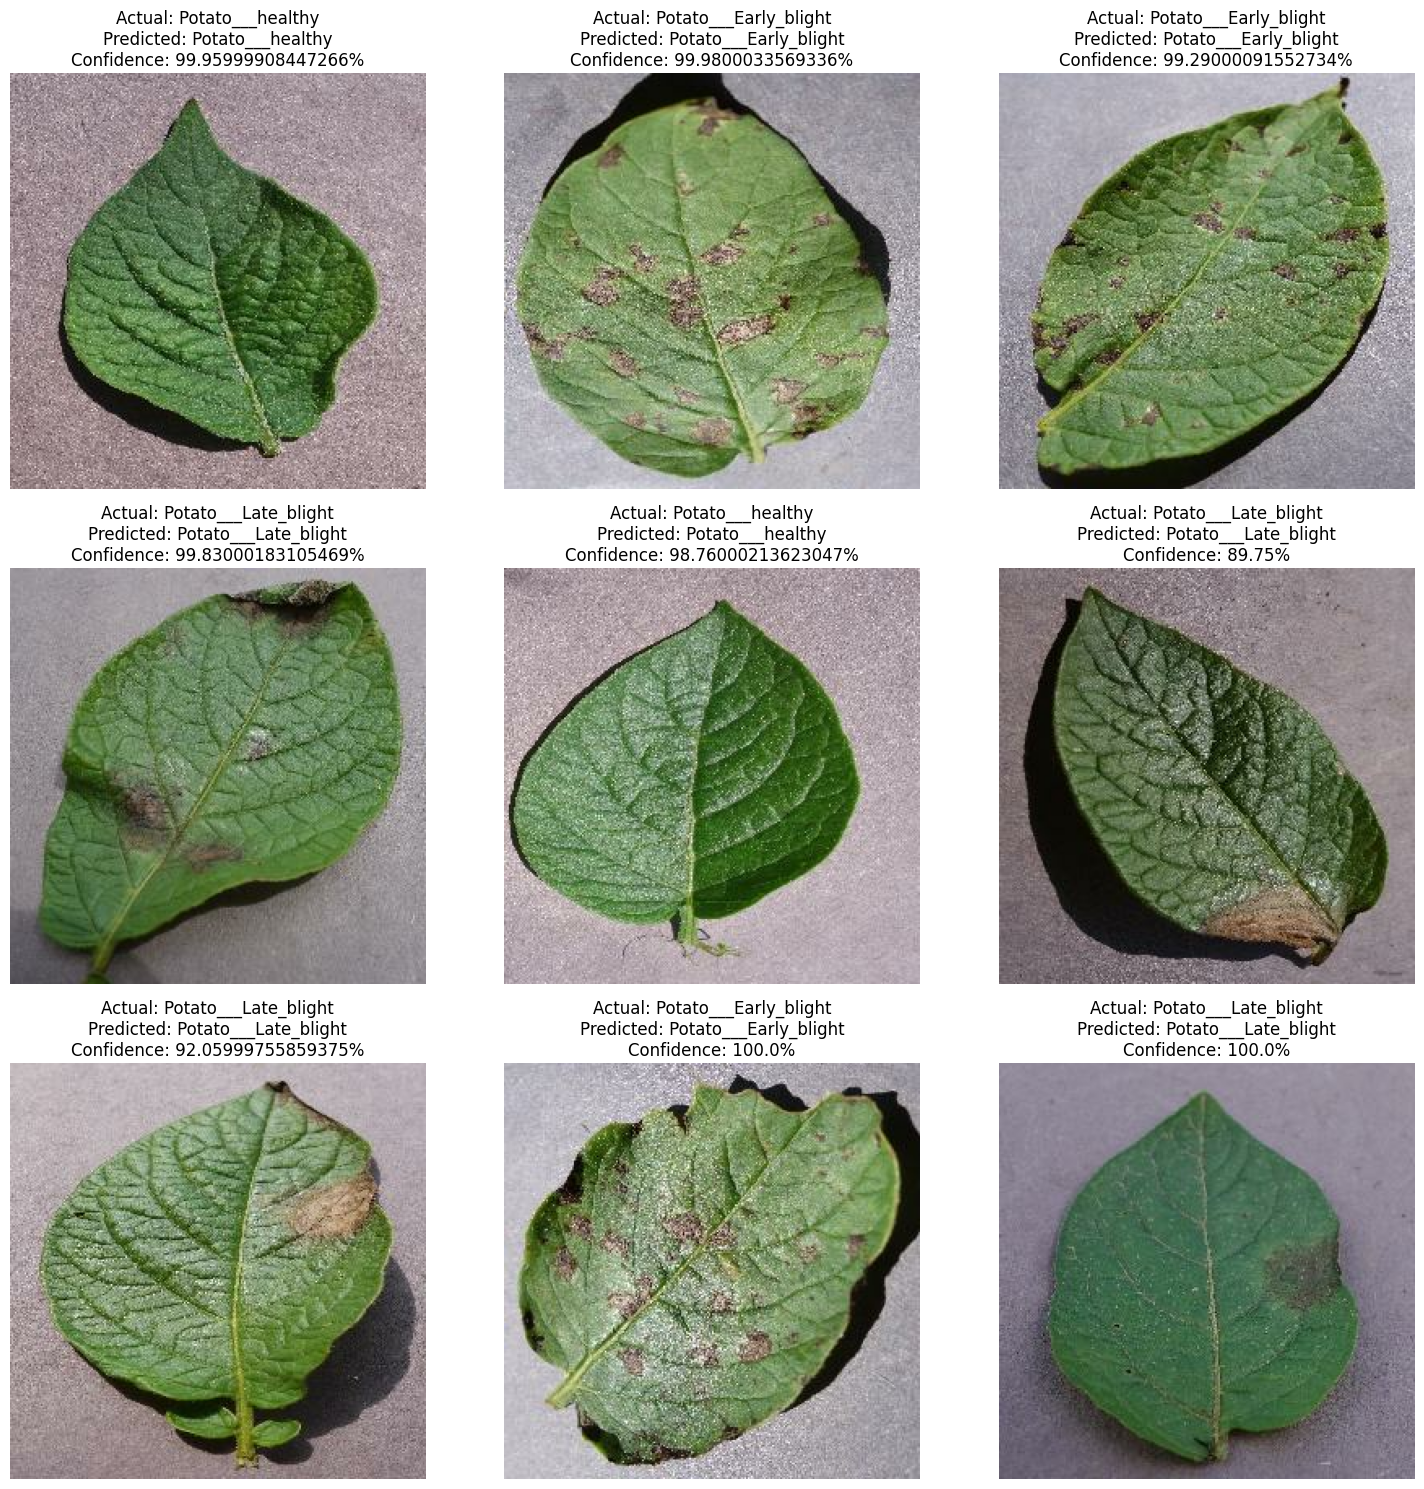

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to make prediction on a single image
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Shape: (1, height, width, 3)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

# Visualize predictions on a batch of test images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):  # Take one batch from test dataset
    for i in range(min(9, len(images))):  # Display 9 images or less if batch is smaller
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[tf.argmax(labels[i]).numpy()] if len(labels[i].shape) > 0 and labels[i].shape[-1] > 1 else class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

plt.tight_layout()
plt.show()


# Gram-CAM

In [18]:
def generate_gradcam(model, image, class_index, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

def predict_and_visualize_specific_classes(model, test_ds, class_names):

    last_conv = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv = layer.name
            break
    if last_conv is None:
        raise ValueError("No Conv2D layer found in the model.")


    target_indices = {}
    for idx, name in enumerate(class_names):
        readable = name.split("___")[-1].replace("_", " ").title()
        if readable in ("Healthy", "Early Blight", "Late Blight"):
            target_indices[readable] = idx


    selected = {}
    for image, label in test_ds.unbatch():
        label_idx = np.argmax(label.numpy())
        for name, idx in target_indices.items():
            if label_idx == idx and name not in selected:
                selected[name] = (image, label)
        if len(selected) == 3:
            break


    if len(selected) < 3:
        missing = set(["Healthy", "Early Blight", "Late Blight"]) - set(selected.keys())
        raise ValueError(f"Could not find samples for: {missing}")


    plt.figure(figsize=(12, 9))
    for i, label_name in enumerate(["Healthy", "Early Blight", "Late Blight"]):
        image, _ = selected[label_name]
        true_class = label_name

        # Expand dims for batch input
        img_array = tf.expand_dims(image, axis=0)
        preds = model.predict(img_array, verbose=0)[0]
        pred_idx = np.argmax(preds)
        pred_label = class_names[pred_idx].split("___")[-1].replace("_", " ").title()
        confidence = round(100 * np.max(preds), 2)


        heatmap = generate_gradcam(model, image, pred_idx, last_conv)
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))


        ax1 = plt.subplot(3, 2, 2 * i + 1)
        plt.imshow(image.numpy())
        plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
        plt.axis("off")
        ax1.set_title(
            f"{true_class} Example\nPredicted: {pred_label} ({confidence}%)",
            fontsize=10
        )


        ax2 = plt.subplot(3, 2, 2 * i + 2)
        im = ax2.imshow(heatmap_resized, cmap="jet")
        plt.axis("off")
        ax2.set_title("Grad-CAM", fontsize=9)
        plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


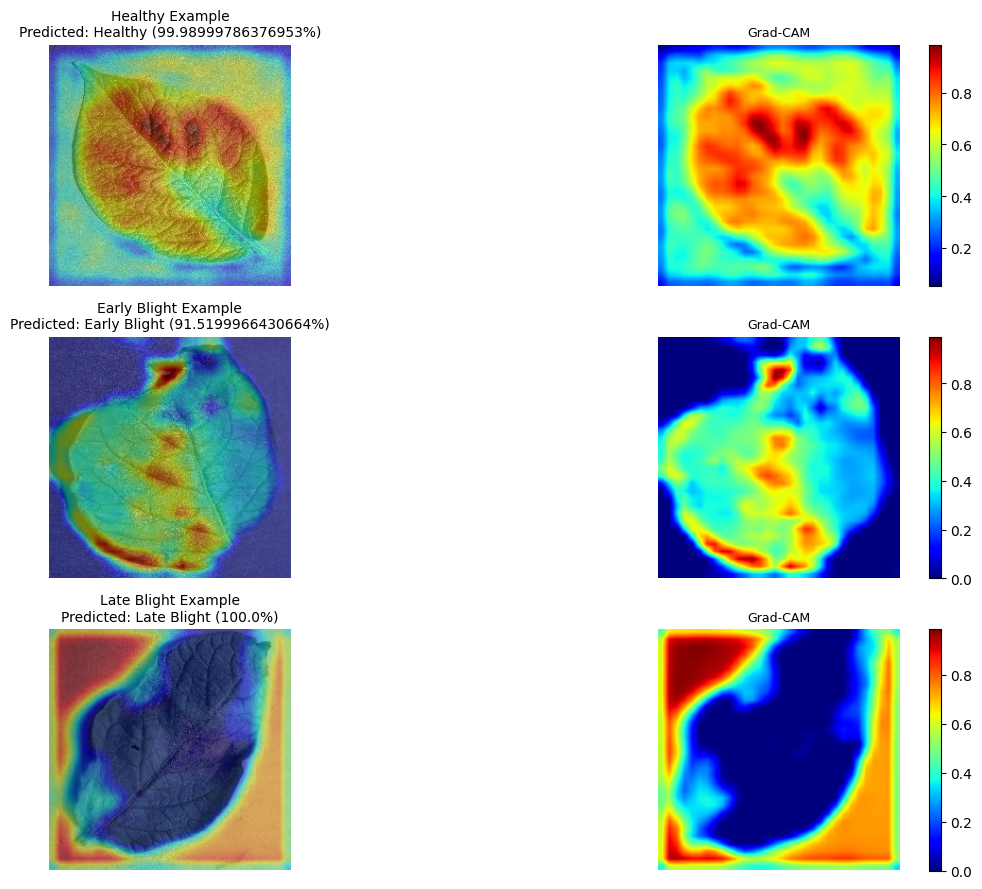

In [20]:
predict_and_visualize_specific_classes(model, test_ds, class_names)


# Gram-CAM on Misclassified Samples

In [21]:
def visualize_misclassified_gradcam(model, test_ds, class_names, max_samples=5):
    # Find the last conv layer name
    last_conv = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv = layer.name
            break
    if last_conv is None:
        raise ValueError("No Conv2D layer found in the model.")

    misclassified = []

    # Collect misclassified samples
    for image, label in test_ds.unbatch():
        true_idx = np.argmax(label.numpy())
        img_array = tf.expand_dims(image, axis=0)
        preds = model.predict(img_array, verbose=0)[0]
        pred_idx = np.argmax(preds)

        if pred_idx != true_idx:
            misclassified.append((image, true_idx, pred_idx, preds[pred_idx]))

        if len(misclassified) >= max_samples:
            break

    if not misclassified:
        print("No misclassified samples found in the test set.")
        return

    plt.figure(figsize=(12, 5 * len(misclassified)))
    for i, (image, true_idx, pred_idx, confidence) in enumerate(misclassified):
        heatmap = generate_gradcam(model, image, pred_idx, last_conv)
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

        ax1 = plt.subplot(len(misclassified), 2, 2 * i + 1)
        ax1.imshow(image.numpy())
        ax1.imshow(heatmap_resized, cmap="jet", alpha=0.5)
        ax1.axis("off")
        ax1.set_title(
            f"True: {class_names[true_idx].split('___')[-1].replace('_', ' ').title()} | "
            f"Pred: {class_names[pred_idx].split('___')[-1].replace('_', ' ').title()} "
            f"({confidence:.2%})",
            fontsize=10
        )

        ax2 = plt.subplot(len(misclassified), 2, 2 * i + 2)
        im = ax2.imshow(heatmap_resized, cmap="jet")
        ax2.axis("off")
        ax2.set_title("Grad-CAM Heatmap", fontsize=9)
        plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


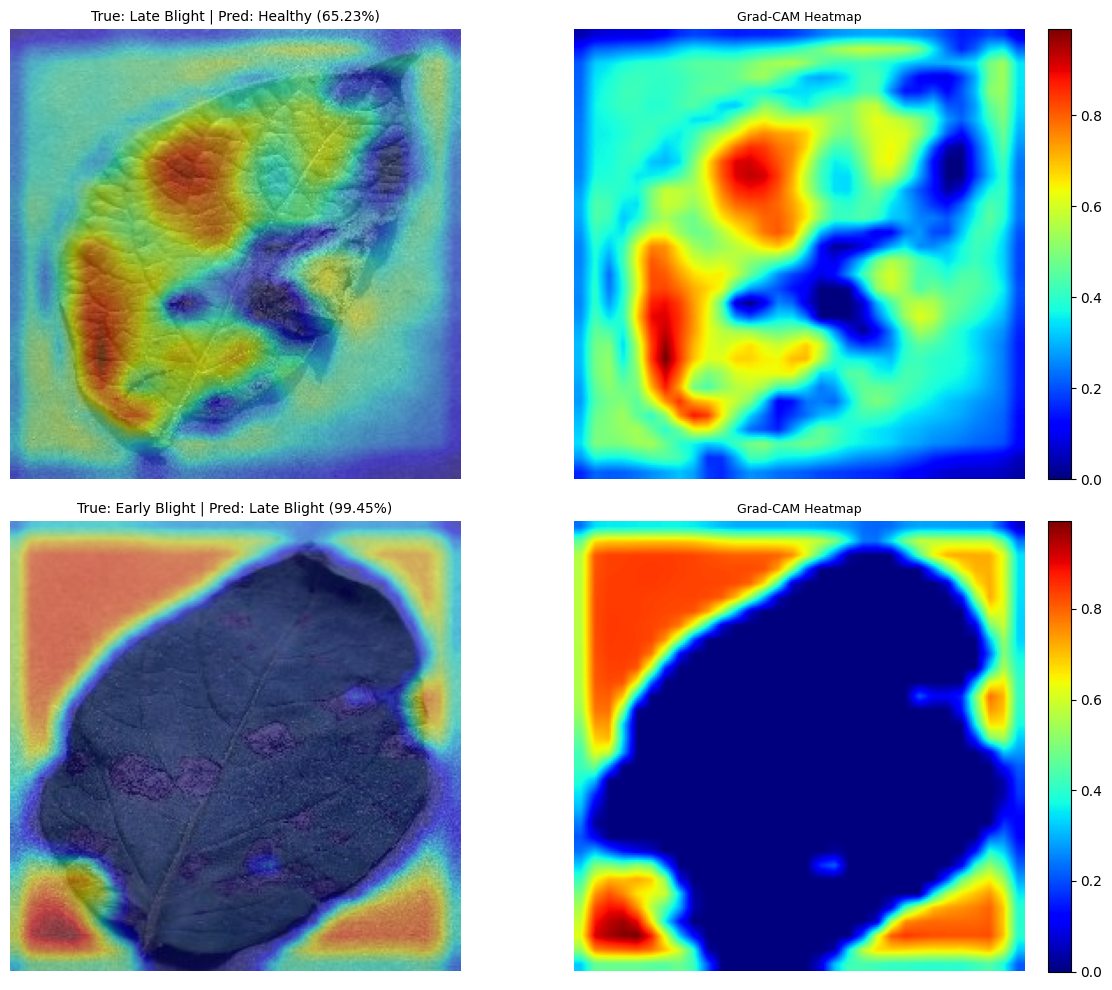

In [22]:
visualize_misclassified_gradcam(model, test_ds, class_names, max_samples=3)


# Three-Way Clustering on a Single Grad-CAM Heatmap

In [23]:

def apply_three_way_clustering_on_gradcam(model, image, class_index, last_conv_layer_name):
    # Step 1: Generate Grad-CAM heatmap
    heatmap = generate_gradcam(model, image, class_index, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Step 2: Flatten heatmap and normalize
    flat_heatmap = heatmap_resized.flatten().reshape(-1, 1)

    # Step 3: Apply K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42).fit(flat_heatmap)
    labels = kmeans.labels_.reshape(heatmap_resized.shape)

    # Step 4: Sort clusters by mean intensity (low → high)
    cluster_means = [heatmap_resized[labels == i].mean() for i in range(3)]
    sorted_clusters = np.argsort(cluster_means)

    region_map = np.zeros_like(labels, dtype=np.uint8)
    region_map[labels == sorted_clusters[0]] = 0  # Reject (low)
    region_map[labels == sorted_clusters[1]] = 1  # Defer (medium)
    region_map[labels == sorted_clusters[2]] = 2  # Accept (high)

    return heatmap_resized, region_map


In [37]:
def visualize_four_panel_gradcam_clustering_with_metrics(image, heatmap, region_map,
                                                          true_label=None, pred_label=None, confidence=None):
    plt.figure(figsize=(14, 4))

    # Panel 1: Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy())
    plt.title("Original Image")
    plt.axis("off")

    # Panel 2: Grad-CAM Overlay
    plt.subplot(1, 4, 2)
    plt.imshow(image.numpy())
    plt.imshow(heatmap, cmap="jet", alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")

    # Panel 3: Raw Cluster Labels
    plt.subplot(1, 4, 3)
    plt.imshow(region_map, cmap="Set1")
    plt.title("Three-Way Regions")
    plt.axis("off")

    # Panel 4: Color-Coded Accept/Defer/Reject
    masked = np.zeros_like(image.numpy())
    for i in range(3):
        mask = (region_map == i)
        color = [1, 0, 0] if i == 0 else [1, 1, 0] if i == 1 else [0, 1, 0]
        for c in range(3):
            masked[:, :, c] += mask * color[c]
    masked = np.clip(masked, 0, 1)

    plt.subplot(1, 4, 4)
    plt.imshow(masked)
    title = "Accept/Defer/Reject"
    if true_label and pred_label:
        title += f"\nTrue: {true_label}, Pred: {pred_label} ({confidence:.2f}%)"
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Return % of each region type
    total_pixels = region_map.size
    pct_accept = 100 * np.sum(region_map == 2) / total_pixels
    pct_defer = 100 * np.sum(region_map == 1) / total_pixels
    pct_reject = 100 * np.sum(region_map == 0) / total_pixels

    return {
        "Accept % (before mask)": pct_accept,
        "Defer % (before mask)": pct_defer,
        "Reject % (before mask)": pct_reject
    }


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


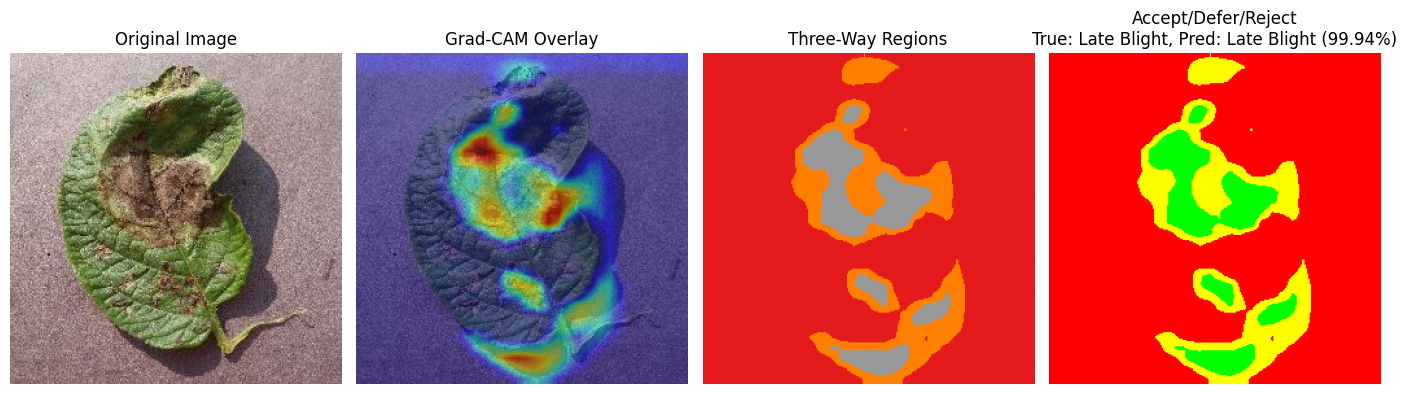

Sample   True Label   Pred Label  Confidence  Accept % (before mask)  \
0       1  Late Blight  Late Blight   99.940002                7.969666   

   Defer % (before mask)  Reject % (before mask)  
0              12.806702               79.223633

In [40]:
import pandas as pd

xai_rows = []

for image, label in test_ds.unbatch().take(1):
    true_idx = np.argmax(label.numpy())
    preds = model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]
    pred_idx = np.argmax(preds)
    confidence = preds[pred_idx] * 100

    last_conv = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv = layer.name
            break

    heatmap, region_map = apply_three_way_clustering_on_gradcam(model, image, pred_idx, last_conv)

    true_label = class_names[true_idx].split("___")[-1].replace("_", " ").title()
    pred_label = class_names[pred_idx].split("___")[-1].replace("_", " ").title()

    metrics = visualize_four_panel_gradcam_clustering_with_metrics(
        image, heatmap, region_map,
        true_label=true_label,
        pred_label=pred_label,
        confidence=confidence
    )

    # Store for table
    row = {
        "Sample": 1,
        "True Label": true_label,
        "Pred Label": pred_label,
        "Confidence": round(confidence, 2),
        **metrics
    }

    xai_rows.append(row)

# Preview the result
df = pd.DataFrame(xai_rows)
display(df)


# Leaf Masking

In [26]:
def create_leaf_mask(image):
    img_np = (image.numpy() * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary_mask = (mask_cleaned > 0).astype(np.float32)
    return binary_mask


In [27]:
def apply_masked_three_way_gradcam(model, image, class_index, last_conv_layer_name):
    heatmap = generate_gradcam(model, image, class_index, last_conv_layer_name)
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    mask = create_leaf_mask(image)

    masked_heatmap = heatmap_resized * mask
    flat_heatmap = masked_heatmap[mask > 0].reshape(-1, 1)

    kmeans = KMeans(n_clusters=3, random_state=42).fit(flat_heatmap)

    full_labels = np.zeros_like(masked_heatmap.flatten(), dtype=np.uint8)
    full_labels[mask.flatten() > 0] = kmeans.labels_
    region_map = full_labels.reshape(masked_heatmap.shape)

    cluster_means = [masked_heatmap[region_map == i].mean() for i in range(3)]
    sorted_clusters = np.argsort(cluster_means)

    final_map = np.zeros_like(region_map, dtype=np.uint8)
    final_map[region_map == sorted_clusters[0]] = 0  # Reject
    final_map[region_map == sorted_clusters[1]] = 1  # Defer
    final_map[region_map == sorted_clusters[2]] = 2  # Accept

    return heatmap_resized, final_map, mask


In [42]:
def visualize_five_panel_xai_with_metrics(image, heatmap, region_map, mask,
                                          true_label=None, pred_label=None, confidence=None):
    plt.figure(figsize=(16, 4))

    # Panel 1: Original Image
    plt.subplot(1, 5, 1)
    plt.imshow(image.numpy())
    plt.title("Original Image")
    plt.axis("off")

    # Panel 2: Leaf Mask
    plt.subplot(1, 5, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Leaf Mask")
    plt.axis("off")

    # Panel 3: Grad-CAM Overlay
    plt.subplot(1, 5, 3)
    plt.imshow(image.numpy())
    plt.imshow(heatmap, cmap="jet", alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")

    # Panel 4: Clustered Regions
    plt.subplot(1, 5, 4)
    plt.imshow(region_map, cmap="Set1")
    plt.title("Three-Way Regions")
    plt.axis("off")

    # Panel 5: Color-Coded Accept/Defer/Reject
    color_overlay = np.zeros_like(image.numpy())
    for i in range(3):
        color = [1, 0, 0] if i == 0 else [1, 1, 0] if i == 1 else [0, 1, 0]
        for c in range(3):
            color_overlay[:, :, c] += (region_map == i) * color[c]
    color_overlay = np.clip(color_overlay, 0, 1)

    plt.subplot(1, 5, 5)
    plt.imshow(color_overlay)
    title = "Accept/Defer/Reject"
    if true_label and pred_label:
        title += f"\nTrue: {true_label}, Pred: {pred_label} ({confidence:.2f}%)"
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Masked region map analysis
    masked_pixels = mask.astype(bool)
    total_masked = np.sum(masked_pixels)

    if total_masked == 0:
        return {
            "Accept % (after mask)": 0,
            "Defer % (after mask)": 0,
            "Reject % (after mask)": 0
        }

    pct_accept = 100 * np.sum((region_map == 2) & masked_pixels) / total_masked
    pct_defer  = 100 * np.sum((region_map == 1) & masked_pixels) / total_masked
    pct_reject = 100 * np.sum((region_map == 0) & masked_pixels) / total_masked

    return {
        "Accept % (after mask)": pct_accept,
        "Defer % (after mask)": pct_defer,
        "Reject % (after mask)": pct_reject
    }


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


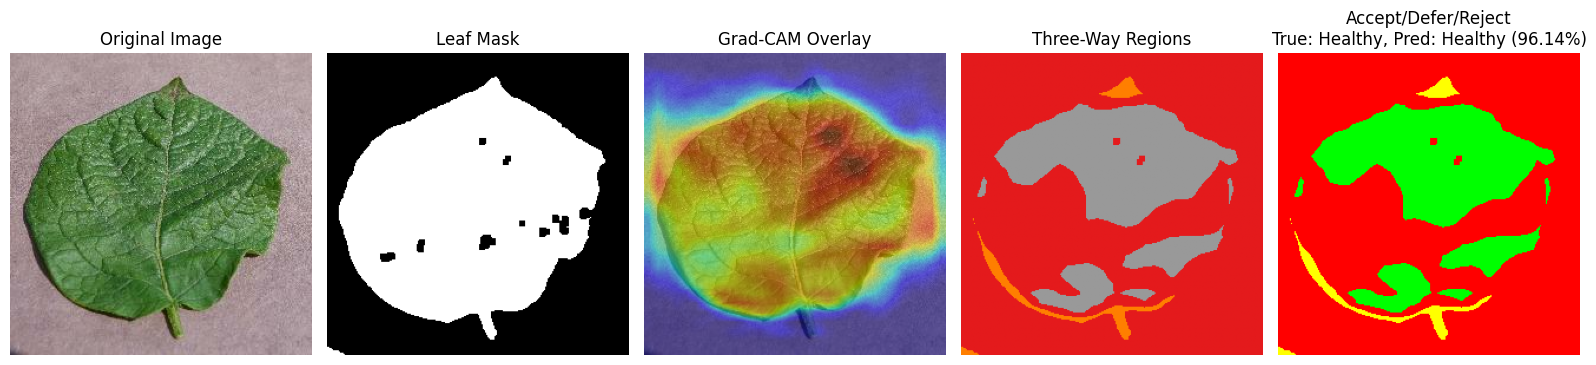

Sample True Label Pred Label  Confidence  Accept % (after mask)  \
0       1    Healthy    Healthy   96.139999              49.326314   

   Defer % (after mask)  Reject % (after mask)  
0              4.728332              45.945353

In [45]:
# Initialize results
xai_rows = []

for image, label in test_ds.unbatch().take(1):
    true_idx = np.argmax(label.numpy())
    preds = model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]
    pred_idx = np.argmax(preds)
    confidence = preds[pred_idx] * 100

    last_conv = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv = layer.name
            break

    # Grad-CAM + clustering + masking
    heatmap, region_map, mask = apply_masked_three_way_gradcam(model, image, pred_idx, last_conv)

    # Labels
    true_label = class_names[true_idx].split("___")[-1].replace("_", " ").title()
    pred_label = class_names[pred_idx].split("___")[-1].replace("_", " ").title()

    # Visualization + metric extraction
    metrics = visualize_five_panel_xai_with_metrics(image, heatmap, region_map, mask,
                                                    true_label, pred_label, confidence)

    row = {
        "Sample": 1,
        "True Label": true_label,
        "Pred Label": pred_label,
        "Confidence": round(confidence, 2),
        **metrics
    }
    xai_rows.append(row)

# Show table
df = pd.DataFrame(xai_rows)
display(df)


In [46]:
import time
import os
import numpy as np

# Sample input (adjust shape if different)
sample_input = np.random.rand(1, 256, 256, 3).astype(np.float32)

# Total number of parameters
param_count = model.count_params()

# Inference time (average of 10 runs)
start = time.time()
for _ in range(10):
    _ = model.predict(sample_input, verbose=0)
end = time.time()
inference_time_ms = ((end - start) / 10) * 1000  # milliseconds

# Save model temporarily to get size
model.save("lightweight_model.h5")
model_size_mb = os.path.getsize("lightweight_model.h5") / (1024 * 1024)

# Print the results
print(f"Model Name        : Lightweight CNN")
print(f"Parameters        : {param_count:,}")
print(f"Inference Time    : {inference_time_ms:.2f} ms")
print(f"Model Size        : {model_size_mb:.2f} MB")


Model Name        : Lightweight CNN
Parameters        : 406,979
Inference Time    : 133.11 ms
Model Size        : 4.74 MB


In [47]:
model.save("Lightweight.keras")